In [ ]:
""" Testing/Debugging File """

"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset, BatchSampler

froot = './data/k562_samp_epft_norm_test_1.csv'
df = pd.read_csv(froot)

print(df.head())

/grid/siepel/home_norepl/hassett/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


  seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0       15  88623545  88623545      +  ENSG00000181026    0.0 -0.079992   
1       15  88623546  88623546      +  ENSG00000181026    0.0 -0.079942   
2       15  88623547  88623547      +  ENSG00000181026    0.0 -0.079893   
3       15  88623548  88623548      +  ENSG00000181026    0.0 -0.079844   
4       15  88623549  88623549      +  ENSG00000181026    0.0 -0.079796   

   h3k36me3   h3k4me1  h3k79me2   h3k9me1   h3k9me3  h4k20me1       sj5  \
0 -0.000099  0.348531  4.423451  0.446508 -0.168099  3.232475 -0.028916   
1  0.001638  0.352677  4.460072  0.453024 -0.169218  3.259194 -0.028916   
2  0.003360  0.356807  4.496664  0.459491 -0.170339  3.285849 -0.028916   
3  0.005065  0.360919  4.533223  0.465908 -0.171461  3.312435 -0.028916   
4  0.006754  0.365013  4.569743  0.472274 -0.172584  3.338952 -0.028916   

        sj3       dms  wgbs      rpts  lambda_alphaj      zeta  
0 -0.057178 -0.307549   0.0  0.24

In [2]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
print(feature_names)
num_samples = df.shape[0]

# process read counts per gene j, site i
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

print("Number of Samples: " + str(num_samples))
print("Number of Features: " + str(num_features))

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values
Y_ji_shape = Y_ji.shape
print(Y_ji.shape)

# read depth * initiation rate values per gene j
C_j = df['lambda_alphaj'].values

gene_ids = df['ensembl_gene_id'].values

cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'wgbs' 'rpts']
Number of Samples: 16182613
Number of Features: 12
(16182613, 12)
CUDA (GPU support) is available: True
Number of GPUs available: 1


In [3]:
class GeneDataset(Dataset):
    def __init__(self, grouped_data, use_sliding_window=False, window_size=None):
        self.grouped_data = grouped_data
        self.use_sliding_window = use_sliding_window
        self.window_size = window_size
        # store windows over sequences
        self.segments = []

        # use subsequence windows from genes
        if self.use_sliding_window and window_size is not None:
            self._create_segments()
        # use full-length genes
        else:
            self._prepare_full_genes()
    
    # create windows over sequences
    def _create_segments(self):
        for gene_id, group in self.grouped_data:
            gene_length = len(group)
            for start_idx in range(0, gene_length - self.window_size + 1, self.window_size):
                end_idx = start_idx + self.window_size
                segment = group.iloc[start_idx:end_idx]
                self.segments.append((gene_id, segment))
    
    def _prepare_full_genes(self):
        for gene_id, group in self.grouped_data:
            self.segments.append((gene_id, group))

    def __len__(self):
        return len(self.segments)

    # prepare single window or gene
    def __getitem__(self, idx):
        gene_id, segment = self.segments[idx]
        
        y_ji_array = np.array(segment['Y_ji'].tolist()).reshape(-1, 12)
        y_ji_tensor = torch.tensor(y_ji_array, dtype=torch.float64)
        
        data = segment.drop(columns=[col for col in ['GeneId', 'dataset', 'Y_ji'] if col in segment.columns])
        tensor_data = torch.tensor(data.values, dtype=torch.float64)
        
        result = {
            'GeneId': gene_id,
            'Y_ji': y_ji_tensor,
            'gene_length': len(segment)
        }
        for col in data.columns:
            result[col] = tensor_data[:, data.columns.get_loc(col)]

        return result

In [4]:
from torch.utils.data import BatchSampler

class GeneIdBatchSampler(BatchSampler):
    def __init__(self, dataset, drop_last=False):
        self.dataset = dataset
        self.drop_last = drop_last
        self.batches = self._create_batches()

    def _create_batches(self):
        # Group indices by GeneId
        gene_id_to_indices = {}
        for idx in range(len(self.dataset)):
            gene_id = self.dataset[idx]['GeneId']
            if gene_id not in gene_id_to_indices:
                gene_id_to_indices[gene_id] = []
            gene_id_to_indices[gene_id].append(idx)

        return list(gene_id_to_indices.values())

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

In [7]:
from sklearn.model_selection import train_test_split

data = pd.DataFrame({
    'GeneId': gene_ids,
    'Y_ji': [row for row in Y_ji],
    'X_ji': X_ji,
    'C_j': C_j,
    'Z_ji': Z_ji
})

grouped = data.groupby('GeneId')

# split by gene into train, val, test sets
train_idx, temp_idx = train_test_split(list(grouped.groups.keys()), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# create dictionary mapping each gene id to its assigned train, val, test dataset labels
dataset_mapping = {gene_id: 'train' for gene_id in train_idx}
dataset_mapping.update({gene_id: 'val' for gene_id in val_idx})
dataset_mapping.update({gene_id: 'test' for gene_id in test_idx})

# filter rows based on assigned dataset field
data['dataset'] = data['GeneId'].map(dataset_mapping)
train_data = data[data['dataset'] == 'train']
valid_data = data[data['dataset'] == 'val']
test_data = data[data['dataset'] == 'test']

print("train data size: " + str(len(train_data)))
print("val data size: " + str(len(valid_data)))
print("test data size: " + str(len(test_data)) + "\n")

train_data = train_data.groupby('GeneId')
valid_data = valid_data.groupby('GeneId')
test_data = test_data.groupby('GeneId')
print("train # genes: " + str(len(train_data)))
print("val # genes: " + str(len(valid_data)))
print("test # genes: " + str(len(test_data)))

train data size: 12713808
val data size: 1798949
test data size: 1669856

train # genes: 415
val # genes: 52
test # genes: 52


In [8]:
def build_dataset(train_data, use_sliding_window=False, window_size=None):
    dataset = GeneDataset(train_data, use_sliding_window, window_size)
    batch_sampler = GeneIdBatchSampler(dataset)
    loader = DataLoader(dataset, batch_sampler=batch_sampler, shuffle=False, num_workers=7, pin_memory=True)
    return loader

In [18]:
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(model_type, num_lstm_layers, bidirectional, hidden_layer_sizes, activation_func,
                num_cnn_layers, num_linear_layers, filter_size, pool_size, dropout, window_size, 
                weight_init):
    
    class LinearModel(nn.Module):
        def __init__(self, input_size):
            super(LinearModel, self).__init__()
            self.name = "linear"
            self.linear = nn.Linear(input_size, 1, bias=False)

        def forward(self, x):
            x = self.linear(x)
            return x
    
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_layer_sizes, output_size, num_layers, bidirectional):
            super(LSTMModel, self).__init__()
            self.name = "lstm"
            self.lstm = nn.LSTM(input_size, hidden_layer_sizes[0], num_layers, bidirectional=bidirectional, batch_first=True)
            self.bidirectional_linear = nn.Linear(2 * hidden_layer_sizes[0], output_size)
            self.linear = nn.Linear(hidden_layer_sizes[0], output_size)
            self.bidirectional = bidirectional

        def forward(self, x):
            x, _ = self.lstm(x)
            if self.bidirectional:
                x = self.bidirectional_linear(x)
            else:
                x = self.linear(x)
            return x
        
    class DenseNet(nn.Module):
        def __init__(self, input_size, hidden_layer_sizes, output_size, dropout, activation='relu'):
            super(DenseNet, self).__init__()
            
            self.name = "dense"
            
            layers = []

            # Define the input layer
            prev_size = input_size

            for size in hidden_layer_sizes:
                layers.append(nn.Linear(prev_size, size))

                if activation.lower() == 'leakyrelu':
                    layers.append(nn.LeakyReLU())
                elif activation.lower() == 'relu':
                    layers.append(nn.ReLU())
                elif activation.lower() == 'tanh':
                    layers.append(nn.Tanh())
                else:
                    raise ValueError("Unsupported activation function")

                prev_size = size
                
            layers.append(nn.Dropout(0.5))

            layers.append(nn.Linear(prev_size, output_size))

            self.layers = nn.Sequential(*layers)

        def forward(self, x):
            return self.layers(x)

    class DeepChromeCNN(nn.Module): 
        def __init__(self, input_size, hidden_layer_sizes, filter_size, pool_size, dropout, window_size):
            super(DeepChromeCNN, self).__init__()
            self.name = "dc_cnn"
            self.conv1d = nn.Conv1d(input_size, hidden_layer_sizes[0], filter_size)
            self.relu = nn.ReLU()
            self.maxpool1d = nn.MaxPool1d(pool_size)
            
            self.dropout = nn.Dropout(dropout)
            self.linear1_input_size = math.ceil((window_size-filter_size)/pool_size)*hidden_dc_cnn_sizes[0]
            self.linear1 = nn.Linear(self.linear1_input_size, hidden_dc_cnn_sizes[1])
            self.linear2 = nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2])
            self.linear3 = nn.Linear(hidden_layer_sizes[2], window_size)
            

        def forward(self, x):
            x = x.permute(0, 2, 1)
            x = self.conv1d(x)
            x = self.relu(x)
            x = self.maxpool1d(x)
            
            x = x.view(-1, self.linear1_input_size)
            x = self.dropout(x)
            x = self.linear1(x)
            x = self.relu(x)
            x = self.linear2(x)
            x = self.relu(x)
            x = self.linear3(x)
            
            return x
        
    class CNN(nn.Module): 
        def __init__(self, input_size, hidden_layer_sizes, filter_size, pool_size, dropout, window_size):
            super(CNN, self).__init__()
            self.name = "cnn"
            self.window_size = window_size
            self.conv1d1 = nn.Conv1d(input_size, hidden_layer_sizes[0], filter_size)
            self.relu = nn.ReLU()
            self.maxpool1d = nn.MaxPool1d(pool_size)
            self.conv1d2 = nn.Conv1d(hidden_layer_sizes[0], hidden_layer_sizes[1], filter_size)
            self.dropout = nn.Dropout(dropout)
            self.linear1_input_size = self.get_linear1_input_size(hidden_layer_sizes, window_size, filter_size, pool_size)
            self.linear1 = nn.Linear(self.linear1_input_size, window_size)
        
        def get_linear1_input_size(self, hidden_layer_sizes, window_size, filter_size, pool_size):
            num_hidden_layers = len(hidden_layer_sizes)
            dim1_size = hidden_layer_sizes[-1]
            dim2_size = window_size
            for _ in range(num_hidden_layers):
                # cnn layer filter shrinks dim (e.g. 100 -> 91)
                dim2_size = dim2_size - filter_size + 1
                # max pool rounds down for pooling (grouping by pool_size)
                dim2_size = math.floor(dim2_size / pool_size)
            # linear layer takes flattened [x, y] -> [x * y]
            return dim1_size * dim2_size
            
        def forward(self, x):
            x = x.permute(0, 2, 1)
            batch_size = x.shape[0]
            x = self.conv1d1(x)
            x = self.relu(x)
            x = self.maxpool1d(x)
            x = self.conv1d2(x)
            x = self.relu(x)
            x = self.maxpool1d(x)

            x = x.view(batch_size, -1)
            x = self.dropout(x)
            x = self.linear1(x)
            
            return x
    
    if model_type == 'lstm':
        model = LSTMModel(num_features, hidden_layer_sizes, 1, num_lstm_layers, bidirectional)
    elif model_type == 'linear':
        model = LinearModel(num_features)
    elif model_type == 'dense':
        model = DenseNet(num_features, hidden_layer_sizes, 1, activation_func)
    elif model_type == 'dc_cnn':
        model = DeepChromeCNN(num_features, hidden_layer_sizes, filter_size, pool_size, dropout, window_size)
    elif model_type == 'cnn':
        model = CNN(num_features, hidden_layer_sizes, filter_size, pool_size, dropout, window_size)
        
    
    if cuda_available:
        #if num_gpus > 1:
            #print("Using", num_gpus, "GPUs")
            #model = torch.nn.DataParallel(model)
        model = model.to('cuda')

    print(model)
    
    """
    # print # model parameters
    arr = torch.randn((1,12,2000)).to(device)
    print(model(arr).shape)
    nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of parameters: " + str(nparm))
    """

    first_param_device = next(model.parameters()).device
    print("Model is on device:", first_param_device)
    
    # expected weights are close to 0 which is why 0 initializing weights converges much quicker
    if weight_init == 'zero':
        with torch.no_grad():
            for param in model.parameters():
                param.zero_()
    
    model.double()

    return model.to(device)

In [19]:
def build_optimizer(network, optimizer, learning_rate, momentum):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=momentum)
        
    # Adam optimizer adapts the learning rate for each parameter individually
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

In [20]:
def valid_epoch(model, loader, loss_fn):
    model.eval()
    total_neural_net_loss = 0
    total_glm_loss = 0
    neural_net_zeta = []
    glm_zeta = []
    
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            Z_ji_batch = batch['Z_ji'].to(device)
            lengths = batch['gene_length'].to(device)
            
            outputs = model(Y_ji_batch)
            
            """
            if model.name == 'dc_cnn2':
                rho_ji = outputs
            else:
                rho_ji = outputs.squeeze(2)
            """
            
            neural_net_loss = loss_fn(X_ji_batch, C_j_batch, outputs, lengths) # remove outputs.squeeze(2) for cnn
            glm_loss = loss_fn(X_ji_batch, C_j_batch, torch.log(Z_ji_batch), lengths)

            total_neural_net_loss +=  neural_net_loss.item()
            total_glm_loss += glm_loss.item()
            
            # store all predictions in list
            neural_net_zeta.append(torch.exp(outputs.cpu()[0]))
            glm_zeta.append(batch['Z_ji'][0])
    
    # calculate average loss across all batches
    avg_neural_net_loss = total_neural_net_loss / len(loader)
    avg_glm_loss = total_glm_loss / len(loader)
    
    neural_net_zeta = torch.cat(neural_net_zeta, dim=0)
    glm_zeta = torch.cat(glm_zeta, dim=0)
    
    return avg_neural_net_loss, avg_glm_loss, neural_net_zeta, glm_zeta

In [21]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for idx, batch in enumerate(loader):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device) 
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        lengths = batch['gene_length'].to(device)
        
        #print(Y_ji_batch.shape)
        outputs = model(Y_ji_batch)
        
        """
        if model.name == 'dc_cnn2':
            rho_ji = outputs
        else:
            rho_ji = outputs.squeeze(2)
        """
        #print(outputs.shape)
        #outputs = outputs.squeeze(2)
        #print(outputs.shape)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs, lengths) # remove outputs.squeeze(2) for cnn
        loss.backward()
        optimizer.step()
        
        # calculate average loss across all batches
        total_loss += loss.item()
    avg_train_loss = total_loss / len(loader)
    
    return avg_train_loss

In [22]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji, lengths):
        C_j_value = C_j[0]
        loss = X_ji * rho_ji + C_j_value * torch.exp(-rho_ji) - X_ji * torch.log(C_j_value)
        
        # normalize loss by sequence length
        loss_sum = loss.sum(dim=1)
        normalized_loss = loss_sum / lengths.float()
        
        # calculate average loss within each batch
        return (normalized_loss).sum()#.mean()

In [23]:
# model configs
model_type = 'cnn'
weight_init = None
hidden_layer_sizes = [64, 128] # lstm - 100, cnn - [32, 64, 128]
activation_func = 'relu'

# lstm configs
num_lstm_layers = 1
bidirectional = True

# deep chrome cnn configs
filter_size = 5#10
pool_size = 2#5
dropout = 0.5
num_linear_layers = 2
num_cnn_layers = 1

# dataset configs
use_sliding_window = True
window_size = 100

# optimizer configs
learning_rate = 1e-4
optimizer_type = 'adam'
momentum = 0

In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
epochs = 30

def train():
    model = build_model(model_type, num_lstm_layers, bidirectional, hidden_layer_sizes, 
                        activation_func, num_cnn_layers, num_linear_layers, 
                        filter_size, pool_size, dropout, window_size, weight_init)
    
    train_loader = build_dataset(train_data, use_sliding_window, window_size)
    valid_loader = build_dataset(valid_data, use_sliding_window, window_size)
    
    optimizer = build_optimizer(model, optimizer_type, learning_rate, momentum)
    
    loss_fn = CustomLoss()
    # track loss curves
    loss_neural_net_train = [0] * epochs
    loss_neural_net_valid = [0] * epochs
    loss_glm_valid = [0] * epochs
    
    # scheduler to reduce learning rate by half when new validation loss > old validation loss
    old_train_loss = float('inf')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')
        
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
        loss_neural_net_train[epoch] = train_loss
        print(f"train loss: {train_loss: .4f}")
        
        valid_neural_net_loss, valid_glm_loss, neural_net_zeta, glm_zeta = valid_epoch(model, valid_loader, loss_fn)
        loss_neural_net_valid[epoch] = valid_neural_net_loss
        loss_glm_valid[epoch] = valid_glm_loss
        print(f"valid neural net loss: {valid_neural_net_loss: .4f}")
        print(f"valid glm loss: {valid_glm_loss: .4f}")
        
        # compute metrics
        mae = F.l1_loss(neural_net_zeta.squeeze(), glm_zeta)
        mse = F.mse_loss(neural_net_zeta.squeeze(), glm_zeta)
        correlation_coefficient = np.corrcoef(glm_zeta, neural_net_zeta.squeeze())[0, 1]
        print("Correlation Coefficient:", correlation_coefficient)
        print(f"Mean Absolute Error: {mae.item():.4f}")
        print(f"Mean Squared Error: {mse.item():.4f}")
        
        # reduce learning rate if new loss > old loss
        if train_loss > old_train_loss:
            optimizer.param_groups[0]['lr'] *= 0.5
            print(f"Reduced learning rate to {optimizer.param_groups[0]['lr']}")
        old_train_loss = train_loss
        scheduler.step(train_loss)
        
    return model

In [ ]:
model = train()

CNN(
  (conv1d1): Conv1d(12, 64, kernel_size=(5,), stride=(1,))
  (relu): ReLU()
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1d2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2816, out_features=100, bias=True)
)
Model is on device: cuda:0
Epoch 1


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train loss:  29.3350


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid neural net loss:  26.2867
valid glm loss:  26.2901
Correlation Coefficient: 0.8510353147767703
Mean Absolute Error: 0.1355
Mean Squared Error: 0.0362
Epoch 2


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [23]:
# save model parameters

from datetime import datetime
"""
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/CNN_Elongation_Model.pth"
torch.save(model.state_dict(), filename)
"""

'\ntimestamp = datetime.now().strftime("%Y%m%d_%H%M%S")\nfilename = f"models/CNN_Elongation_Model.pth"\ntorch.save(model.state_dict(), filename)\n'

In [62]:
# load model state

model = build_model(model_type, num_lstm_layers, lstm_hidden_layer_size, bidirectional,
                    dense_hidden_layer_sizes, dense_activation_func, hidden_dc_cnn_sizes, filter_size, 
                    pool_size, dropout, window_size, weight_init)

model.load_state_dict(torch.load("models/Linear_Elongation_Model_Windows_100.pth"))

cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

model.double()

NameError: name 'lstm_hidden_layer_size' is not defined

In [63]:
weights = model.linear.weight.data.cpu().numpy()
combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

AttributeError: 'DataParallel' object has no attribute 'linear'

In [25]:
glm_kappa = [-0.0224536145637661, -0.094592589, -0.023815382, 0.030402922, -0.067234092, -0.032196914, -0.040911478, -0.018557168, -0.033545905, -0.051103287, -0.204434712, 0.015831043]

In [ ]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.09
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.04
* sj5: -0.02
* sj3: -0.03
* dms->stem-loop: -0.05
* rpts->low-complex: +0.01
* wgbs->DNAm: -0.2
"""

In [ ]:
# plot loss curve

epochs = range(1, len(loss_neural_net_train) + 1)
plt.plot(epochs, loss_train, label='train_neural_net_loss')
plt.plot(epochs, loss_neural_net_valid, label='valid_neural_net_loss')
plt.plot(epochs, loss_glm_valid, label='valid_glm_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [17]:
def plot_data(glm_zeta, net_zeta):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta', s=10, alpha=0.5)
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta', s=10, alpha=0.5)
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()
    
    plt.ylim(0.5, 1.3)

    plt.show()


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


number of samples: 6


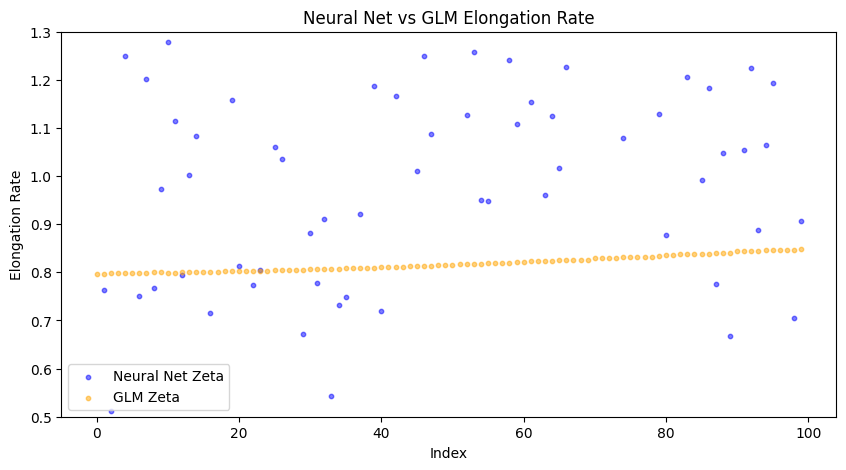

number of samples: 6


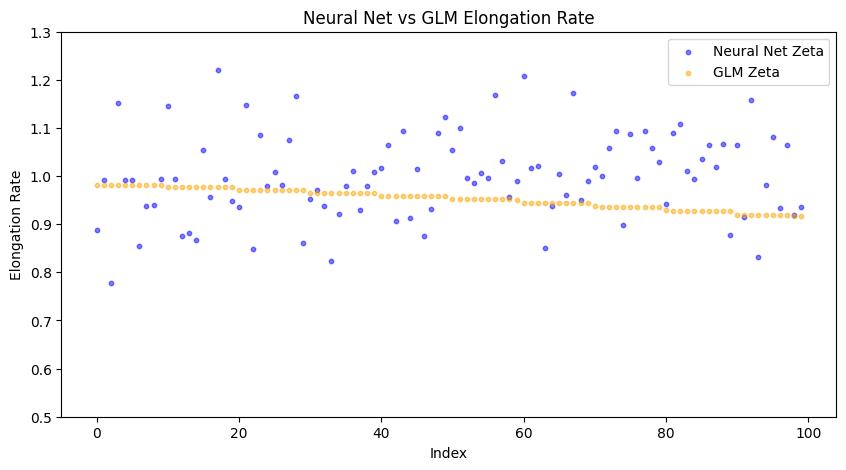

number of samples: 6


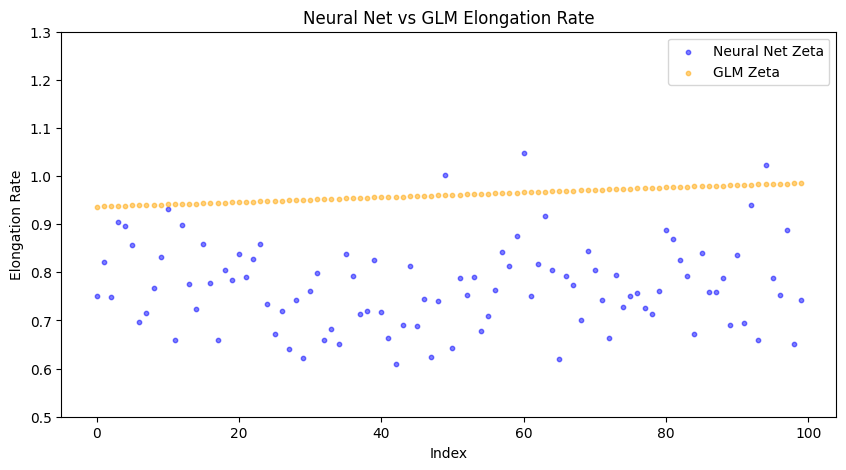

number of samples: 6


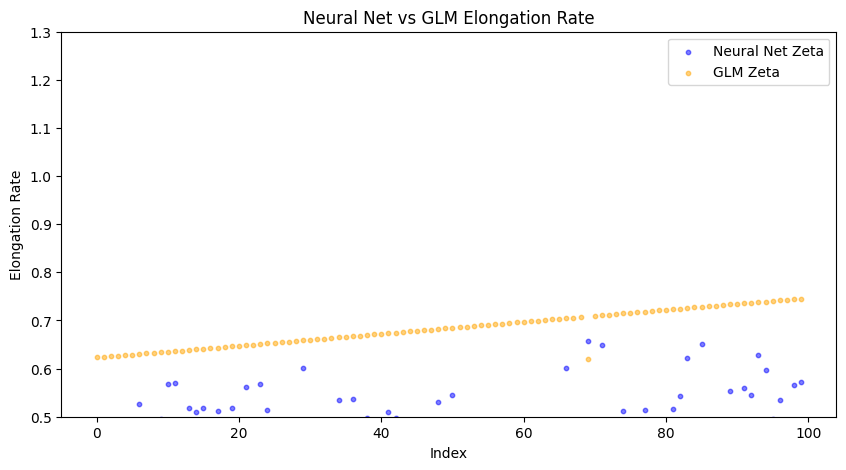

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [18]:
model.eval()

tstdl = build_dataset(test_data, use_sliding_window, window_size)
data_iter = iter(tstdl)

# plot for subset of genes in test dataset
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        #print(rho_ji)

    glm_zeta = inputs['Z_ji']#[0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
    
    plot_data(glm_zeta[0], net_zeta[0])

In [34]:
# compute metrics for test dataset

net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()[0]))
        glm_zeta.append(batch['Z_ji'][0])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Correlation Coefficient: 0.9905561364147403
Mean Absolute Error: 0.0165
Mean Squared Error: 0.0005


In [54]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
            
    plt.xlim([min(glm_zeta), max(glm_zeta)])
    plt.ylim([min(net_zeta), max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [55]:
def scatterplot(net_zeta, glm_zeta, gene_id):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [ ]:
# plot for all genes in test dataset

total_loss = 0
loss_fn = CustomLoss()
for batch in tstdl:
    gene_id = batch['GeneId'][0]
    model.eval()

    with torch.no_grad():
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        
    glm_zeta = batch['Z_ji'][0]
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
    density_plot(glm_zeta, net_zeta, gene_id)
                
    plot_data(glm_zeta, net_zeta)

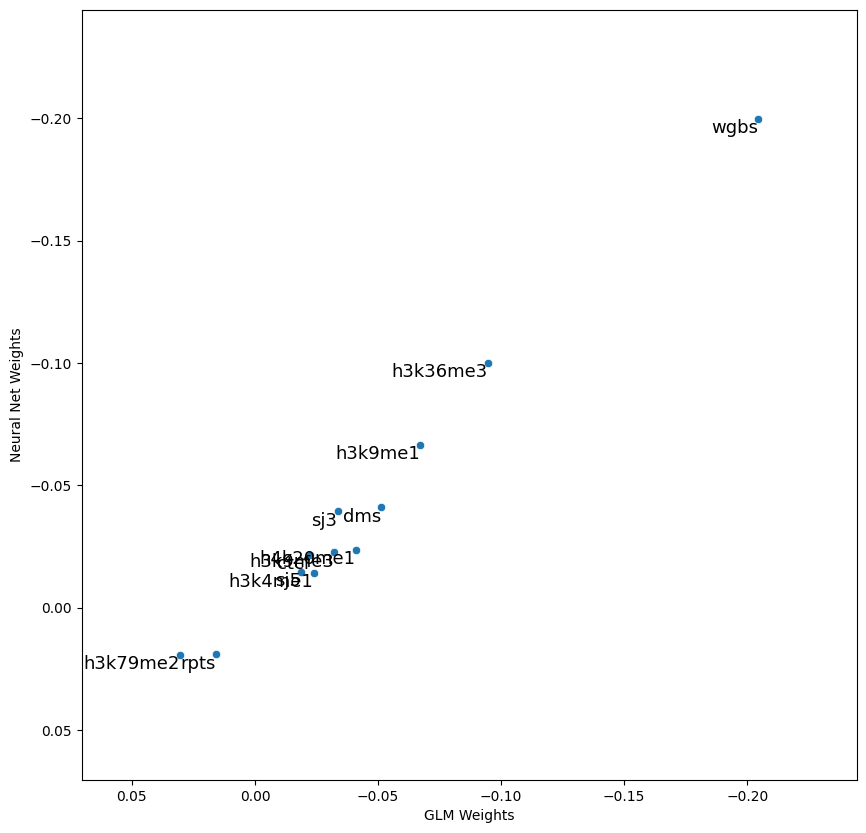

In [35]:
# plot scatterplot of neural net weights and glm weights

plt.figure(figsize=(10, 10))

sns.scatterplot(x=glm_kappa, y=weights[0])

for i in range(len(glm_kappa)):
    plt.text(glm_kappa[i], weights[0][i], feature_names[i], fontsize=13, ha='right', va='top')
plt.xlabel('GLM Weights')
plt.ylabel('Neural Net Weights')

max_val = max(np.max(glm_kappa), np.max(weights[0])) + 0.04
min_val = min(np.min(glm_kappa), np.min(weights[0])) - 0.04

plt.xlim(max_val, min_val)
plt.ylim(max_val, min_val)

# Show the plot
plt.show()